In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml
from typing import Union, Optional, Type, Tuple, List, Dict
import sys
from skimage.color import label2rgb
import json
# import nrrd

import pandas as pd
import seaborn as sns
# Project Root
# used for searching packages and functions
# TODO: enter your project root dir here
ROOT_DIR = '/project/Xie_Lab/zgu/xiao_multiplex/multiTAP/image_cytof'

sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'image_cytof'))
from cytof.hyperion_preprocess import cytof_read_data_roi
from cytof.utils import save_multi_channel_img, check_feature_distribution
from cytof.classes import CytofImageTiff
from cytof.classes import CytofCohort

/project/Xie_Lab/zgu/conda_stuff/envs/cytof-shared/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def flatten_coexpression_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flattens a symmetric co-expression matrix (including the diagonal)
    into a single-row wide-format DataFrame.
    
    Parameters:
        df (pd.DataFrame): A square symmetric DataFrame of co-expression values.
        
    Returns:
        pd.DataFrame: A single-row wide-format DataFrame where each column is a
                      unique pair (e.g., 'GeneA_GeneB') and the value is the
                      corresponding co-expression score.
    """
    if df.shape[0] != df.shape[1]:
        raise ValueError("Input DataFrame must be square.")
    if not df.columns.equals(df.index):
        raise ValueError("DataFrame must have matching row and column labels.")

    # Get upper triangle indices (including diagonal)
    mask = np.triu(np.ones(df.shape), k=0).astype(bool)
    i, j = np.where(mask)

    # Build column names and extract values
    colnames = [f"{df.index[r]}_{df.columns[c]}" for r, c in zip(i, j)]
    values = df.values[i, j]

    # Return as single-row wide-format DataFrame
    return pd.DataFrame([values], columns=colnames)


# read from saved csv
these csv contains flattened values of co-expression, i.e. long format

In [43]:
# concatenate all files 
SAVED_GROUPS = [0,1,2,3,4,5,175]
BASE_CSV_DIR = "/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work"


In [48]:
# combine individual save groups as one
df_list = []
for group in SAVED_GROUPS:
    csv_path = os.path.join(BASE_CSV_DIR, f"nsclc_save_group{group}", f"nsclc_save_group{group}_flattened_coexp.csv")
    df = pd.read_csv(csv_path)

    df_list.append(df)

combined_co_exp_df = pd.concat(df_list, axis=0, ignore_index=True)
combined_co_exp_df

,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Ki-67_142((3418))Pt194-Pt194_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_206Pb-Pb206_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,roi_id
0,2.389949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.365713,0.968170,0.656991,2.110415,0.935796,0.531200,2.016158,0.832462,1.310333,NSCLC_ALL_86_A_A1_1
1,2.525314,0.000000,0.000000,0.049678,0.000000,0.000000,0.941484,0.956723,0.000000,1.053351,...,0.955255,1.088464,0.611343,1.163134,1.034049,0.000000,2.665892,0.000000,2.665892,NSCLC_ALL_86_A_A1_2
2,2.360867,0.868834,0.000000,0.043614,0.472611,0.712725,0.652343,0.835498,0.000000,0.609351,...,0.725250,0.000000,0.526871,0.862903,0.000000,0.260001,0.000000,0.000000,2.405629,NSCLC_ALL_87_A_A4_9
3,1.691831,0.688056,0.373738,0.016630,0.000000,0.000000,0.135236,0.000000,0.000000,0.000000,...,0.461011,1.237895,0.294255,1.130255,0.000000,0.107460,2.682197,0.000000,1.218804,NSCLC_ALL_87_A_A4_10
4,2.287982,0.000000,0.000000,0.000000,0.000000,1.003436,0.000000,1.224696,0.000000,0.000000,...,1.049587,0.000000,0.661496,1.050024,0.000000,0.749004,0.000000,0.000000,0.962892,NSCLC_ALL_87_C_C7_14
5,1.402375,1.329867,1.323217,0.282656,1.277459,1.329867,1.323217,1.402375,1.402347,1.360982,...,0.226541,0.226543,0.226550,1.443709,1.402347,1.188586,1.402375,1.147210,1.188669,NSCLC_ALL_87_C_C7_15
6,2.631730,0.000000,0.000000,-0.240486,0.000000,0.000000,0.662293,0.000000,0.000000,0.000000,...,1.080081,1.074219,0.210301,2.417673,2.056770,0.000000,2.693052,0.000000,0.976278,NSCLC_ALL_178_B_2_B_4_17
7,2.491346,0.000000,0.000000,-0.030648,0.564923,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.891035,1.532083,0.167970,1.341963,1.325895,0.252676,2.635880,0.996719,1.004227,NSCLC_ALL_178_B_2_B_4_18
8,0.755987,0.300027,-0.099770,0.000000,0.579849,0.144125,0.193801,0.167647,-0.031157,0.439643,...,0.762253,1.272804,0.095122,1.494741,1.187184,0.212102,2.610128,0.224759,0.526537,NSCLC_ALL_88_C_C1_2
9,0.815397,0.335667,-0.273739,0.029922,0.032079,0.153720,0.152601,0.000000,-0.507179,0.000000,...,0.929824,0.000000,0.033401,1.221988,0.000000,0.061841,2.675587,0.000000,0.869614,NSCLC_ALL_88_C_C1_3


In [6]:
def extract_roi_id(roi_id):
    try:
        split = roi_id.split('_')
        return f"{split[2]}_{split[4]},{split[5]}"
    except IndexError:
        return None  # or raise an error / return roi_id unchanged


In [50]:
combined_co_exp_df['roi_mappable'] = combined_co_exp_df['roi_id'].apply(extract_roi_id)
combined_co_exp_df

,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Ki-67_142((3418))Pt194-Pt194_cell_sum_206Pb-Pb206_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,roi_id,roi_mappable
0,2.389949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.968170,0.656991,2.110415,0.935796,0.531200,2.016158,0.832462,1.310333,NSCLC_ALL_86_A_A1_1,"86_A1,1"
1,2.525314,0.000000,0.000000,0.049678,0.000000,0.000000,0.941484,0.956723,0.000000,1.053351,...,1.088464,0.611343,1.163134,1.034049,0.000000,2.665892,0.000000,2.665892,NSCLC_ALL_86_A_A1_2,"86_A1,2"
2,2.360867,0.868834,0.000000,0.043614,0.472611,0.712725,0.652343,0.835498,0.000000,0.609351,...,0.000000,0.526871,0.862903,0.000000,0.260001,0.000000,0.000000,2.405629,NSCLC_ALL_87_A_A4_9,"87_A4,9"
3,1.691831,0.688056,0.373738,0.016630,0.000000,0.000000,0.135236,0.000000,0.000000,0.000000,...,1.237895,0.294255,1.130255,0.000000,0.107460,2.682197,0.000000,1.218804,NSCLC_ALL_87_A_A4_10,"87_A4,10"
4,2.287982,0.000000,0.000000,0.000000,0.000000,1.003436,0.000000,1.224696,0.000000,0.000000,...,0.000000,0.661496,1.050024,0.000000,0.749004,0.000000,0.000000,0.962892,NSCLC_ALL_87_C_C7_14,"87_C7,14"
5,1.402375,1.329867,1.323217,0.282656,1.277459,1.329867,1.323217,1.402375,1.402347,1.360982,...,0.226543,0.226550,1.443709,1.402347,1.188586,1.402375,1.147210,1.188669,NSCLC_ALL_87_C_C7_15,"87_C7,15"
6,2.631730,0.000000,0.000000,-0.240486,0.000000,0.000000,0.662293,0.000000,0.000000,0.000000,...,1.074219,0.210301,2.417673,2.056770,0.000000,2.693052,0.000000,0.976278,NSCLC_ALL_178_B_2_B_4_17,"178_2,B"
7,2.491346,0.000000,0.000000,-0.030648,0.564923,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.532083,0.167970,1.341963,1.325895,0.252676,2.635880,0.996719,1.004227,NSCLC_ALL_178_B_2_B_4_18,"178_2,B"
8,0.755987,0.300027,-0.099770,0.000000,0.579849,0.144125,0.193801,0.167647,-0.031157,0.439643,...,1.272804,0.095122,1.494741,1.187184,0.212102,2.610128,0.224759,0.526537,NSCLC_ALL_88_C_C1_2,"88_C1,2"
9,0.815397,0.335667,-0.273739,0.029922,0.032079,0.153720,0.152601,0.000000,-0.507179,0.000000,...,0.000000,0.033401,1.221988,0.000000,0.061841,2.675587,0.000000,0.869614,NSCLC_ALL_88_C_C1_3,"88_C1,3"


In [53]:
# add the clinical data
pt_clinical_data = pd.read_csv('/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/clinical_data_ROI.csv')
# pt_subset = pt_clinical_data[pt_clinical_data['RoiID'].isin(roi_id_list)]
pt_subset = pt_clinical_data[['RoiID','Patient_ID', 'OS', 'DFS', 'Ev.O']]
# pt_subset['OS_one_Year'] = pt_subset['OS'] > 365

# first exclude control from analysis
pt_subset = pt_subset[pt_subset['Patient_ID'] != 'Control']
pt_subset

,RoiID,Patient_ID,OS,DFS,Ev.O
0,"175_A1,1",175_1,254.0,NaN,1.0
1,"175_A1,2",175_5,3420.0,3420.0,1.0
2,"175_A1,3",175_9,1312.0,1312.0,1.0
3,"175_A1,4",175_13,1950.0,1950.0,1.0
4,"175_A1,6",175_21,820.0,820.0,1.0
...,...,...,...,...,...
2065,"88_C8,9",88_521,596.0,370.0,1.0
2066,"88_C8,10",88_525,323.0,323.0,1.0
2067,"88_C8,11",88_529,1707.0,1707.0,0.0
2068,"88_C8,12",88_533,1652.0,1652.0,0.0


In [59]:
counts>2

88_363      True
175_111    False
175_165    False
175_169    False
175_173    False
           ...  
178_387    False
178_383    False
178_379    False
178_423    False
87_250     False
Name: Patient_ID, Length: 1070, dtype: bool

In [61]:
# Count occurrences of each Patient_ID
counts = pt_subset['Patient_ID'].value_counts()

# Convert to DataFrame
counts_df = counts[counts>1].reset_index()
counts_df.columns = ['Patient_ID', 'Count']
patient_order = counts.index.tolist()  # list of Patient_ID sorted by count descending
counts_df

,Patient_ID,Count
0,88_363,3
1,175_111,2
2,175_165,2
3,175_169,2
4,175_173,2
...,...,...
905,88_519,2
906,88_511,2
907,88_507,2
908,88_503,2


In [65]:
counts[counts<=1]
counts

88_363     3
175_111    2
175_165    2
175_169    2
175_173    2
          ..
178_387    1
178_383    1
178_379    1
178_423    1
87_250     1
Name: Patient_ID, Length: 1070, dtype: int64

In [54]:

# Convert Patient_ID column to categorical with this order to sort accordingly
pt_subset['Patient_ID'] = pd.Categorical(pt_subset['Patient_ID'], categories=patient_order, ordered=True)

# Sort the dataframe by Patient_ID categorical order
sorted_df = pt_subset.sort_values('Patient_ID')
small_sorted = sorted_df.head(10)
small_sorted

,RoiID,Patient_ID,OS,DFS,Ev.O
1851,"88_A4,2",88_363,2659.0,2659.0,0.0
1779,"88_A4,2",88_363,2659.0,2659.0,0.0
1765,"88_A3,2",88_363,2659.0,2659.0,0.0
0,"175_A1,1",175_1,254.0,NaN,1.0
16,"175_A2,1",175_1,254.0,NaN,1.0
1363,"87_A1,11",87_202,1068.0,367.0,1.0
1380,"87_A2,11",87_202,1068.0,367.0,1.0
1350,"86_C8,4",86_128,332.0,332.0,0.0
1344,"86_C7,4",86_128,332.0,332.0,0.0
1346,"86_C7,7",86_140,3531.0,3531.0,1.0


In [10]:
# among the pt that have multiple TMA, check OS, DFS, Ev.O are consistent within each pt
columns_to_check = ['OS', 'Ev.O', 'Relapse', 'DFS', 'Smok', 'Relapse']  

# for each pt check # of unique elements in those columns
consistency_df = sorted_df.groupby('Patient_ID')[columns_to_check].nunique()

# each column should only have one
consistency_df['all_consistent'] = (consistency_df <= 1).all(axis=1)

# # get those not consistent
inconsistent_pt = consistency_df[~consistency_df['all_consistent']].reset_index()['Patient_ID']
inconsistent_pt

Series([], Name: Patient_ID, dtype: category
Categories (1070, object): ['88_363' < '175_1' < '87_202' < '86_128' ... '86_133' < '86_145' < '86_149' < '87_250'])

In [11]:
sorted_df[sorted_df['Patient_ID'].isin(inconsistent_pt)]

,RoiID,OS,Ev.O,Relapse,DFS,Smok,Patient_ID


In [12]:
single_row_pt = pt_subset.groupby('Patient_ID').mean()
single_row_pt

/tmp/ipykernel_1165677/4152369970.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  single_row_pt = pt_subset.groupby('Patient_ID').mean()


,OS,Ev.O,Relapse,DFS,Smok
Patient_ID,,,,,
88_363,2659.0,0.0,0.0,2659.0,1.0
175_1,254.0,1.0,NaN,NaN,3.0
87_202,1068.0,1.0,1.0,367.0,1.0
86_128,332.0,0.0,1.0,332.0,1.0
86_140,3531.0,1.0,0.0,3531.0,3.0
...,...,...,...,...,...
86_113,603.0,0.0,0.0,603.0,1.0
86_133,2046.0,0.0,0.0,2046.0,1.0
86_145,710.0,1.0,1.0,554.0,1.0


In [13]:
print(np.unique(single_row_pt['Ev.O'], return_counts=True))
print(np.unique(single_row_pt['Smok'], return_counts=True))
print(np.unique(single_row_pt['Relapse'], return_counts=True))

# print(len(np.unique(pt_subset['Patient_ID'])))

(array([ 0.,  1., nan]), array([337, 730,   3]))
(array([ 0.,  1.,  2.,  3., nan]), array([ 86, 730,  26, 197,  31]))
(array([ 0.,  1., nan]), array([555, 480,  35]))


In [68]:
combined_df['OS_one_Year'] = pt_subset['OS_one_Year'].values
combined_df

,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Ki-67_142((3418))Pt194-Pt194_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_206Pb-Pb206_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,OS_one_Year
0,2.389949,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.365713,0.968170,0.656991,2.110415,0.935796,0.531200,2.016158,0.832462,1.310333,True
1,2.525314,0.0,0.000000,0.049678,0.000000,0.000000,0.941484,0.956723,0.0,1.053351,...,0.955255,1.088464,0.611343,1.163134,1.034049,0.000000,2.665892,0.000000,2.665892,False
2,1.871431,0.0,-0.005308,0.019321,0.144955,0.851278,0.000000,0.000000,0.0,0.000000,...,0.999691,0.000000,0.695943,1.294854,0.000000,0.554505,0.000000,0.000000,1.258287,False


In [70]:
from sklearn.linear_model import LogisticRegression

# Select features (co-expression values) and binary outcome
X = combined_df.drop(columns=['OS_one_Year'])  # or 'survived_1yr'
y = combined_df['OS_one_Year']  # or 'survived_1yr'

# Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)



LogisticRegression(max_iter=1000)

In [71]:
# Get feature coefficients
coef = model.coef_[0]
feature_importance = pd.Series(coef, index=X.columns)

# Sort by absolute value to see strongest effects
feature_importance_abs = feature_importance.abs().sort_values(ascending=False)
print("Top features by absolute coefficient (unregularized):")
print(feature_importance_abs.head(10))

Top features by absolute coefficient (unregularized):
p75(CD2_1840((2193))Tb159-Tb159_cell_sum_p75(CD2_1840((2193))Tb159-Tb159_cell_sum    0.052324
117Sn-Sn117_cell_sum_117Sn-Sn117_cell_sum                                            0.049987
FSP1 S1_2263((3411))In113-In113_cell_sum_K-Cadhe_2600((3417))Yb176-Yb176_cell_sum    0.049932
Podopla_1463((2619))Eu153-Eu153_cell_sum_CD34_2254((3337))Er170-Er170_cell_sum       0.047473
FSP1 S1_2263((3411))In113-In113_cell_sum_Indolea_2281((3014))Eu151-Eu151_cell_sum    0.044211
Indolea_2281((3014))Eu151-Eu151_cell_sum_K-Cadhe_2600((3417))Yb176-Yb176_cell_sum    0.042148
Podopla_1463((2619))Eu153-Eu153_cell_sum_CD279(P_1743((3414))Gd155-Gd155_cell_sum    0.041359
Podopla_1463((2619))Eu153-Eu153_cell_sum_Vimenti_655((1939))Dy162-Dy162_cell_sum     0.040346
VCAM1_1986((3332))Nd148-Nd148_cell_sum_CD20_36((3369))Sm149-Sm149_cell_sum           0.039529
117Sn-Sn117_cell_sum_FOXP3_115((2911))Dy163-Dy163_cell_sum                           0.038305
dtype:

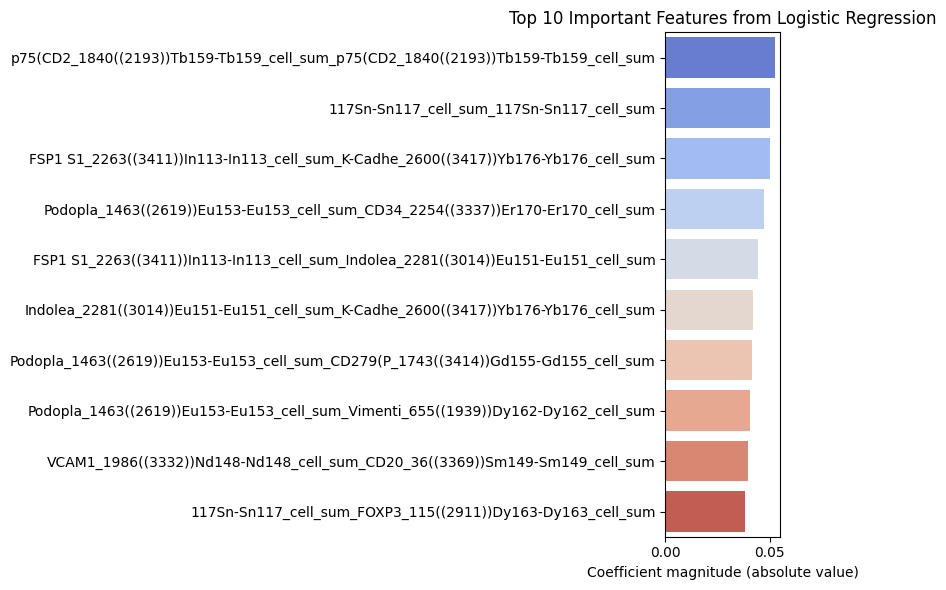

In [72]:
# Select top 10 features by absolute coefficient value
top_features = feature_importance_abs.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')

plt.xlabel('Coefficient magnitude (absolute value)')
plt.title('Top 10 Important Features from Logistic Regression')
plt.tight_layout()
plt.show()

# scratch

In [ ]:
"""

For each save group in sequential [0,1,2,3,4,5,175]
-	Load the corresponding pkl file 
-	subset pt_id_savegroup into that group, exclude pt_id that are already processed.
-	further subset to pt that are saved in ONE group only
-	for all patients in the refined subset, index the two TMAs, put them into ONE cohort, run cohort.coexpression, save as flattened df. Mark processed pt_id.
-	Now for the patients in TWO groups, load the next save group pkl, index from the two .pkl with ONE cytof_img each
-	Put the two into ONE cohort, then save as flattened df. Mark processed pt_id
-	Delete variable additional loaded pkl

"""

In [23]:
# Example symmetric co-expression matrix
df = pd.DataFrame({
    'GeneA': [1.0, 0.8, 0.5],
    'GeneB': [0.8, 1.0, 0.6],
    'GeneC': [0.5, 0.6, 1.0]
}, index=['GeneA', 'GeneB', 'GeneC'])

# Get upper triangle indices (including diagonal)
mask = np.triu(np.ones(df.shape), k=0).astype(bool)
i, j = np.where(mask)

# Build column names and values
colnames = [f"{df.index[r]}_{df.columns[c]}" for r, c in zip(i, j)]
values = df.values[i, j]

# Create wide-format DataFrame
flat_df = pd.DataFrame([values], columns=colnames)
flat_df

,GeneA_GeneA,GeneA_GeneB,GeneA_GeneC,GeneB_GeneB,GeneB_GeneC,GeneC_GeneC
0,1.0,0.8,0.5,1.0,0.6,1.0


In [3]:
batch_pt_slides_path = '/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group0/nsclc_save_group0.pkl'
cytof_cohort_whole_slide = pkl.load(open(batch_pt_slides_path, 'rb'))
roi_list = list(cytof_cohort_whole_slide.cytof_images.keys())
roi_list = roi_list[:2]


In [3]:
# add the clinical data
pt_clinical_data = pd.read_csv('/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/clinical_data_ROI.csv')
# pt_subset = pt_clinical_data[pt_clinical_data['RoiID'].isin(roi_id_list)]
pt_subset = pt_clinical_data[['RoiID','Patient_ID', 'OS', 'DFS', 'Ev.O']]
# pt_subset['OS_one_Year'] = pt_subset['OS'] > 365

# first exclude control from analysis
# pt_subset = pt_subset[pt_subset['Patient_ID'] != 'Control']
pt_subset

,RoiID,Patient_ID,OS,DFS,Ev.O
0,"175_A1,1",175_1,254.0,NaN,1.0
1,"175_A1,2",175_5,3420.0,3420.0,1.0
2,"175_A1,3",175_9,1312.0,1312.0,1.0
3,"175_A1,4",175_13,1950.0,1950.0,1.0
4,"175_A1,6",175_21,820.0,820.0,1.0
...,...,...,...,...,...
2067,"88_C8,11",88_529,1707.0,1707.0,0.0
2068,"88_C8,12",88_533,1652.0,1652.0,0.0
2069,"88_C8,13",88_537,621.0,189.0,1.0
2070,"88_C8,14",Control,NaN,NaN,NaN


In [19]:
test = '178_A_A_1_2'
test.startswith('178')

True

In [4]:
def extract_roi_id(roi_id):
    try:

        # first split by _
        split = roi_id.split('_')
        # special case for 178 A and C
        if roi_id.startswith('178_A') or roi_id.startswith('178_C'):
            return f"{split[0]}_{split[2]}{split[3]},{split[4]}"
        elif roi_id.startswith('178_B'): # special case for 178 B
            return f"{split[0]}_{split[3]}{split[4]},{split[5]}"
        else: # all other cases
            return f"{split[0]}_{split[2]},{split[3]}"
    except IndexError:
        return None  # or raise an error / return roi_id unchanged


In [5]:
# load save_group info
save_group1 = pd.read_csv("/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_all.csv")
save_group2 = pd.read_csv("/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_group175_only.csv")

save_group_all = pd.concat([save_group1, save_group2]).reset_index(drop=True)
save_group_all['roi_mappable'] = save_group_all['ROI'].apply(extract_roi_id)
save_group_all

,SLIDE,ROI,input file,save_group,roi_mappable
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,1"
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,2"
2,NSCLC_ALL,86_A_A1_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,5"
3,NSCLC_ALL,86_A_A1_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,6"
4,NSCLC_ALL,86_A_A1_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,7"
...,...,...,...,...,...
2065,NSCLC_ALL,175_C_C8_12,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,12"
2066,NSCLC_ALL,175_C_C8_13,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,13"
2067,NSCLC_ALL,175_C_C8_14,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,14"
2068,NSCLC_ALL,175_C_C8_15,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,15"


In [33]:
pt_id_savegroup = save_group_all.merge(pt_subset, how='inner', left_on='roi_mappable', right_on='RoiID')

# remove control bc they can't be in the survival analysis
pt_id_savegroup = pt_id_savegroup[pt_id_savegroup['Patient_ID']!='Control'].reset_index(drop=True)
pt_id_savegroup

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,1","86_A1,1",86_1,2593.0,2593.0,1.0
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,2","86_A1,2",86_5,158.0,158.0,1.0
2,NSCLC_ALL,86_A_A1_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,5","86_A1,5",86_17,121.0,NaN,1.0
3,NSCLC_ALL,86_A_A1_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,6","86_A1,6",86_21,521.0,521.0,1.0
4,NSCLC_ALL,86_A_A1_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,7","86_A1,7",86_25,2382.0,1250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1968,NSCLC_ALL,175_C_C8_10,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,10","175_C8,10",175_176,944.0,829.0,1.0
1969,NSCLC_ALL,175_C_C8_11,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,11","175_C8,11",175_180,1061.0,1061.0,1.0
1970,NSCLC_ALL,175_C_C8_12,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,12","175_C8,12",175_184,3027.0,3027.0,0.0
1971,NSCLC_ALL,175_C_C8_13,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,13","175_C8,13",175_188,1458.0,1255.0,1.0


In [62]:
test_group = pt_id_savegroup[pt_id_savegroup['save_group']==6]
consistency_df = test_group.groupby('Patient_ID')[['save_group']].nunique()
consistency_df['in_same_group'] = (consistency_df <= 1).all(axis=1)
consistency_df[~consistency_df['in_same_group']]

,save_group,in_same_group
Patient_ID,,


,save_group,in_same_group
Patient_ID,,


In [21]:
# in_clinical_not_save = set(pt_subset['RoiID']) - set(pt_id_savegroup['RoiID'])
# len(in_clinical_not_save)

115

In [63]:
pt_id_savegroup[pt_id_savegroup['Patient_ID']=='176_323']

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
1422,NSCLC_ALL,176_C_C5_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,1","176_C5,1",176_323,3022.0,3022.0,0.0
1434,NSCLC_ALL,176_C_C6_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,1","176_C6,1",176_323,3022.0,3022.0,0.0


In [22]:
print(len(set(pt_subset['Patient_ID'])))
print(len(set(pt_id_savegroup['Patient_ID'])))

1071
1069


In [67]:
# pt_id_savegroup.head(20)

# among the pt that have multiple TMA, check OS, DFS, Ev.O are consistent within each pt
columns_to_check = ['save_group']  

# for each pt check # of unique elements in those columns
consistency_df = pt_id_savegroup.groupby('Patient_ID')[columns_to_check].nunique()
# each column should only have one
consistency_df['in_same_group'] = (consistency_df <= 1).all(axis=1)
consistency_df

,save_group,in_same_group
Patient_ID,,
175_1,1,True
175_10,1,True
175_100,1,True
175_101,1,True
175_102,1,True
...,...,...
88_534,1,True
88_535,1,True
88_536,1,True


In [68]:
consistency_df

,save_group,in_same_group
Patient_ID,,
175_1,1,True
175_10,1,True
175_100,1,True
175_101,1,True
175_102,1,True
...,...,...
88_534,1,True
88_535,1,True
88_536,1,True


In [72]:
print(len(consistency_df[~consistency_df['in_same_group']]))
two_group_pt = consistency_df[~consistency_df['in_same_group']].index
two_group_pt

32


Index(['176_323', '176_327', '176_331', '176_335', '176_339', '176_343',
       '176_347', '176_351', '176_355', '176_359', '178_507', '178_511',
       '87_195', '87_199', '87_207', '87_211', '87_215', '87_223', '87_227',
       '87_301', '87_305', '87_313', '87_317', '87_321', '87_325', '87_329',
       '87_333', '87_337', '87_341', '87_345', '87_349', '88_486'],
      dtype='object', name='Patient_ID')

In [78]:
pt_id_savegroup[pt_id_savegroup['Patient_ID'].isin(two_group_pt)].sort_values(by='Patient_ID').head(40)

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
1434,NSCLC_ALL,176_C_C6_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,1","176_C6,1",176_323,3022.0,3022.0,0.0
1422,NSCLC_ALL,176_C_C5_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,1","176_C5,1",176_323,3022.0,3022.0,0.0
1435,NSCLC_ALL,176_C_C6_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,2","176_C6,2",176_327,461.0,369.0,1.0
1423,NSCLC_ALL,176_C_C5_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,2","176_C5,2",176_327,461.0,369.0,1.0
1436,NSCLC_ALL,176_C_C6_3,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,3","176_C6,3",176_331,2.0,2.0,1.0
1424,NSCLC_ALL,176_C_C5_3,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,3","176_C5,3",176_331,2.0,2.0,1.0
1437,NSCLC_ALL,176_C_C6_4,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,4","176_C6,4",176_335,485.0,61.0,1.0
1425,NSCLC_ALL,176_C_C5_4,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,4","176_C5,4",176_335,485.0,61.0,1.0
1438,NSCLC_ALL,176_C_C6_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,5","176_C6,5",176_339,2446.0,524.0,0.0
1426,NSCLC_ALL,176_C_C5_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,5","176_C5,5",176_339,2446.0,524.0,0.0


In [8]:
df_cohort = cytof_cohort_whole_slide.df_cohort
df_cohort['roi_mappable'] = df_cohort['ROI'].apply(extract_roi_id)
df_cohort

,SLIDE,ROI,input file,roi_mappable
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
2,NSCLC_ALL,86_A_A1_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
3,NSCLC_ALL,86_A_A1_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
4,NSCLC_ALL,86_A_A1_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
...,...,...,...,...
295,NSCLC_ALL,87_A_A4_4,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
296,NSCLC_ALL,87_A_A4_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
297,NSCLC_ALL,87_A_A4_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
298,NSCLC_ALL,87_A_A4_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None


In [74]:
ctyof_cohorts_dict = dict()

for roi in roi_list:
    ctyof_cohorts_dict[f'{roi}'] = cytof_cohort_whole_slide.cytof_images[f'{roi}']

ctyof_cohorts_dict

{'NSCLC_ALL_86_A_A1_1': CytofImage(slide=NSCLC_ALL, roi=86_A_A1_1),
 'NSCLC_ALL_86_A_A1_2': CytofImage(slide=NSCLC_ALL, roi=86_A_A1_2)}

In [75]:
cytof_cohort_of_one = CytofCohort(cytof_images=ctyof_cohorts_dict, dir_out=None) # save all cohorts as one, not individually
cytof_cohort_of_one.batch_process_feature()
cytof_cohort_of_one.generate_summary()

Getting thresholds for cell sum of all markers.


['75normed_sum']

In [76]:
df_cohort = cytof_cohort_of_one.df_cohort.copy()
df_cohort

,Slide,ROI,input file,Slide_ROI
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,NSCLC_ALL_86_A_A1_1
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,NSCLC_ALL_86_A_A1_2


In [81]:
# go through each roi, get their binary marker-cell expression
roi_binary_express_dict = dict()
for i, cytof_img in enumerate(cytof_cohort_of_one.cytof_images.values()):
    slide, roi = cytof_img.slide, cytof_img.roi
    df_binary_pos_exp = cytof_img.get_binary_pos_express_df("75normed", "sum")
    roi_binary_express_dict[roi] = df_binary_pos_exp
roi_binary_express_dict

{'86_A_A1_1':       Myelope_276((2996))Y89-Y89_cell_sum  \
 0                                   False   
 1                                   False   
 2                                   False   
 3                                   False   
 4                                   False   
 ...                                   ...   
 1569                                False   
 1570                                False   
 1571                                False   
 1572                                False   
 1573                                False   
 
       FSP1 S1_2263((3411))In113-In113_cell_sum  \
 0                                        False   
 1                                        False   
 2                                        False   
 3                                        False   
 4                                        False   
 ...                                        ...   
 1569                                     False   
 1570                    

In [ ]:
# preprocessing setup
# roi_id = 'NSCLC_ALL_86_A_A1_1'
df_feature_name = 'df_feature_75normed'
accumul_type = 'sum'
flat_marker_pt_list = []

for roi_id in roi_list:
    print(f'Processing roi {roi_id}...')

    # extract individual patients
    ind_cytof_img = cytof_cohort_whole_slide.cytof_images[roi_id]
    df_feat = getattr(ind_cytof_img, df_feature_name)
    marker_col_all = [x for x in df_feat.columns if f"cell_{accumul_type}" in x]
    df_cell_sum = df_feat[marker_col_all]

    # get the marker threshold (marker1, markers, ... vs. positive counts, thresholds)
    ind_cytof_img.calculate_quantiles(qs=[75])

    # still need to process features through a batch
    # more likely, the cohort will contain multiple ROIs. Then user will batch process and generate feature summary
    # after summaries are attached to individual ROIs, eahc cytof_img can be called with co-expression-analysis
    cytof_cohort_of_one = CytofCohort(cytof_images={f'{roi_id}':ind_cytof_img}, dir_out=None) # save all cohorts as one, not individually
    cytof_cohort_of_one.batch_process_feature()
    cytof_cohort_of_one.generate_summary()

    # calling the individual ROI co-expression-analysis
    # df_co_pos_prob, df_expected_prob = cytof_img_ind_test.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)
    df_co_pos_prob, df_expected_prob = ind_cytof_img.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)

    epsilon = 1e-6 # avoid divide by 0 or log(0)

    # keep the df labels to calculate edges
    df_edge_perc = np.log10(df_co_pos_prob / (df_expected_prob+epsilon) + epsilon)
    df_edge_perc[df_edge_perc == np.log10(epsilon)] = 0

    per_pt_flat_df = flatten_coexpression_matrix(df_edge_perc)

    per_pt_flat_df['roi_id'] = roi_id

    flat_marker_pt_list.append(per_pt_flat_df)


In [ ]:
combined_df = pd.concat(flat_marker_pt_list, axis=0, ignore_index=True)
combined_df

In [ ]:
%matplotlib inline
# calling the individual ROI co-expression-analysis
# df_co_pos_prob, df_expected_prob = cytof_img_ind_test.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)
df_co_pos_prob, df_expected_prob = ind_cytof_img.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)

epsilon = 1e-6 # avoid divide by 0 or log(0)

# Normalize and fix Nan
edge_percentage_norm = np.log10(df_co_pos_prob.values / (df_expected_prob.values+epsilon) + epsilon)

# if observed/expected = 0, then log odds ratio will have log10(epsilon)
# no observed means co-expression cannot be determined, does not mean strong negative co-expression
edge_percentage_norm[edge_percentage_norm == np.log10(epsilon)] = 0

# do some post processing
marker_all_clean = [m.replace('_cell_sum', '') for m in df_expected_prob.columns]


# fig = plt.figure()
clustergrid = sns.clustermap(edge_percentage_norm,
                # clustergrid = sns.clustermap(edge_percentage_norm,
                center=np.log10(1 + epsilon), cmap='RdBu_r', vmin=-1, vmax=3,
                xticklabels=marker_all_clean, yticklabels=marker_all_clean)

# plt.title(f'{one_slide} ROI:{one_roi}')
plt.title(f'XXX ROI:xxx')

# plt.savefig('figure4a.pdf', format='pdf', dpi=300, bbox_inches='tight') # tight to save all edges of the figure
plt.show()